In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
import os
import shutil

train_folder = '/content/dataset/complete_dataset_edited/train'
images_target = os.path.join(train_folder, 'images')
labels_target = os.path.join(train_folder, 'labels')

# Create target folders if they don't exist
os.makedirs(images_target, exist_ok=True)
os.makedirs(labels_target, exist_ok=True)

# Loop through subfolders in train
for subfolder in os.listdir(train_folder):
    subfolder_path = os.path.join(train_folder, subfolder)
    if os.path.isdir(subfolder_path) and subfolder not in ['images', 'labels']:
        images_folder = os.path.join(subfolder_path, 'images')
        labels_folder = os.path.join(subfolder_path, 'labels')

        if os.path.isdir(images_folder):
            for img_file in os.listdir(images_folder):
                shutil.move(os.path.join(images_folder, img_file),
                            os.path.join(images_target, img_file))

        if os.path.isdir(labels_folder):
            for lbl_file in os.listdir(labels_folder):
                shutil.move(os.path.join(labels_folder, lbl_file),
                            os.path.join(labels_target, lbl_file))

        # Remove the now-empty subfolder
        shutil.rmtree(subfolder_path)


In [ ]:
# import os
# import cv2
# import numpy as np
# from segment_anything import SamPredictor
# from tqdm import tqdm

# # Paths
# base_path = os.path.join(HOME, "dataset", "complete_dataset_edited", "eval")
# image_dir = os.path.join(base_path, "images")
# label_dir = os.path.join(base_path, "labels")
# output_dir = os.path.join(base_path, "masks")
# os.makedirs(output_dir, exist_ok=True)

# # Initialize predictor
# mask_predictor = SamPredictor(sam)

# # Process each image
# for image_file in tqdm(os.listdir(image_dir)):
#     if not image_file.endswith(('.jpg', '.png')):
#         continue

#     image_path = os.path.join(image_dir, image_file)
#     label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + ".txt")

#     if not os.path.isfile(label_path):
#         print(f"Missing label for {image_file}")
#         continue

#     # Load image
#     image_bgr = cv2.imread(image_path)
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#     height, width = image_rgb.shape[:2]

#     # Set image in predictor
#     mask_predictor.set_image(image_rgb)

#     # Read and convert bounding boxes
#     with open(label_path, 'r') as f:
#         lines = f.readlines()

#     for i, line in enumerate(lines):
#         parts = line.strip().split()
#         if len(parts) != 5:
#             continue

#         _, x_center, y_center, box_w, box_h = map(float, parts)
#         x0 = int((x_center - box_w / 2) * width)
#         y0 = int((y_center - box_h / 2) * height)
#         x1 = int((x_center + box_w / 2) * width)
#         y1 = int((y_center + box_h / 2) * height)

#         box = np.array([x0, y0, x1, y1])

#         # Predict mask from box
#         masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

#         # Use the largest mask
#         best_mask = masks[np.argmax([np.sum(m) for m in masks])]

#         # Save mask
#         mask_filename = f"{os.path.splitext(image_file)[0]}_mask_{i}.png"
#         cv2.imwrite(os.path.join(output_dir, mask_filename), best_mask.astype(np.uint8) * 255)


# Stacked masked images-------------------------------------------------
# import os
# import cv2
# import numpy as np
# from segment_anything import SamPredictor
# from tqdm import tqdm

# # Paths
# base_path = os.path.join(HOME, "dataset", "complete_dataset_edited", "eval")
# image_dir = os.path.join(base_path, "images")
# label_dir = os.path.join(base_path, "labels")
# output_dir = os.path.join(base_path, "masks2")
# os.makedirs(output_dir, exist_ok=True)

# # Initialize predictor
# mask_predictor = SamPredictor(sam)

# # Process each image
# for image_file in tqdm(os.listdir(image_dir)):
#     if not image_file.endswith(('.jpg', '.png')):
#         continue

#     image_path = os.path.join(image_dir, image_file)
#     label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + ".txt")

#     if not os.path.isfile(label_path):
#         print(f"Missing label for {image_file}")
#         continue

#     # Load image
#     image_bgr = cv2.imread(image_path)
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#     height, width = image_rgb.shape[:2]

#     # Set image in predictor
#     mask_predictor.set_image(image_rgb)

#     # Initialize empty combined mask
#     combined_mask = np.zeros((height, width), dtype=np.uint8)

#     # Read and convert bounding boxes
#     with open(label_path, 'r') as f:
#         lines = f.readlines()

#     for line in lines:
#         parts = line.strip().split()
#         if len(parts) != 5:
#             continue

#         _, x_center, y_center, box_w, box_h = map(float, parts)
#         x0 = int((x_center - box_w / 2) * width)
#         y0 = int((y_center - box_h / 2) * height)
#         x1 = int((x_center + box_w / 2) * width)
#         y1 = int((y_center + box_h / 2) * height)

#         box = np.array([x0, y0, x1, y1])

#         # Predict masks from box
#         masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

#         # Accumulate best mask (largest area) into combined_mask
#         best_mask = masks[np.argmax([np.sum(m) for m in masks])]
#         combined_mask = np.logical_or(combined_mask, best_mask)

#     # Save final combined mask
#     final_mask = (combined_mask.astype(np.uint8)) * 255
#     mask_filename = f"{os.path.splitext(image_file)[0]}_mask.png"
#     cv2.imwrite(os.path.join(output_dir, mask_filename), final_mask)

# multiclass masking-------------------------------------------p
# import os
# import cv2
# import numpy as np
# from segment_anything import SamPredictor
# from tqdm import tqdm

# # Paths
# base_path = os.path.join(HOME, "dataset", "complete_dataset_edited", "eval")
# image_dir = os.path.join(base_path, "images")
# label_dir = os.path.join(base_path, "labels")
# output_dir = os.path.join(base_path, "masks3-multiclass")
# os.makedirs(output_dir, exist_ok=True)

# # Class names (or IDs) - adjust this based on your actual class names
# class_names = ['title', 'infographics', 'description', 'demonstration_image',
#                'equations', 'graph', 'recording_screen', 'board_data',
#                'board_controls', 'android']

# # Initialize predictor
# mask_predictor = SamPredictor(sam)

# # Process each image
# for image_file in tqdm(os.listdir(image_dir)):
#     if not image_file.endswith(('.jpg', '.png')):
#         continue

#     image_path = os.path.join(image_dir, image_file)
#     label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + ".txt")

#     if not os.path.isfile(label_path):
#         print(f"Missing label for {image_file}")
#         continue

#     # Load image
#     image_bgr = cv2.imread(image_path)
#     image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#     height, width = image_rgb.shape[:2]

#     # Set image in predictor
#     mask_predictor.set_image(image_rgb)

#     # Initialize empty multi-class mask (each class will have its own value)
#     combined_mask = np.zeros((height, width), dtype=np.uint8)

#     # Read and convert bounding boxes
#     with open(label_path, 'r') as f:
#         lines = f.readlines()

#     for line in lines:
#         parts = line.strip().split()
#         if len(parts) != 5:
#             continue

#         class_id, x_center, y_center, box_w, box_h = map(float, parts)
#         class_id = int(class_id)  # Ensure class_id is an integer
#         x0 = int((x_center - box_w / 2) * width)
#         y0 = int((y_center - box_h / 2) * height)
#         x1 = int((x_center + box_w / 2) * width)
#         y1 = int((y_center + box_h / 2) * height)

#         box = np.array([x0, y0, x1, y1])

#         # Predict masks from box
#         masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

#         # Select the best mask (largest area)
#         best_mask = masks[np.argmax([np.sum(m) for m in masks])]

#         # Assign the mask to the class ID in the combined mask
#         combined_mask[best_mask == 1] = class_id  # Set the pixels of the mask to the class ID

#     # Save final combined multi-class mask
#     final_mask = (combined_mask.astype(np.uint8)) * 255  # Convert to 0-255 for saving
#     mask_filename = f"{os.path.splitext(image_file)[0]}_mask.png"
#     cv2.imwrite(os.path.join(output_dir, mask_filename), final_mask)

import os
import cv2
import numpy as np
from segment_anything import SamPredictor
from tqdm import tqdm

# Paths
base_path = os.path.join(HOME, "dataset", "complete_dataset_edited", "train")
image_dir = os.path.join(base_path, "images")
label_dir = os.path.join(base_path, "labels")
output_dir = os.path.join(base_path, "masks2-multiclass-updated")
os.makedirs(output_dir, exist_ok=True)

# Class names (or IDs)
class_names = ['title', 'infographics', 'description', 'demonstration_image',
               'equations', 'graph', 'recording_screen', 'board_data',
               'board_controls', 'android']

# Initialize predictor
mask_predictor = SamPredictor(sam)

# Process each image
for image_file in tqdm(os.listdir(image_dir)):
    if not image_file.endswith(('.jpg', '.png','.JPG')):
        continue

    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + ".txt")

    if not os.path.isfile(label_path):
        print(f"Missing label for {image_file}")
        continue

    # Load image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    height, width = image_rgb.shape[:2]

    # Set image in predictor
    mask_predictor.set_image(image_rgb)

    # Initialize empty mask
    combined_mask = np.zeros((height, width), dtype=np.uint8)

    # Read and apply class-wise masks
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        class_id, x_center, y_center, box_w, box_h = map(float, parts)
        class_id = int(class_id)

        x0 = int((x_center - box_w / 2) * width)
        y0 = int((y_center - box_h / 2) * height)
        x1 = int((x_center + box_w / 2) * width)
        y1 = int((y_center + box_h / 2) * height)

        box = np.array([x0, y0, x1, y1])

        # Predict mask for the bounding box
        masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

        # Choose best mask (largest area)
        best_mask = masks[np.argmax([np.sum(m) for m in masks])]

        # Set class ID in combined mask
        combined_mask[best_mask == 1] = class_id

    # Save mask without scaling to 255 (preserve class IDs as-is)
    mask_filename = f"{os.path.splitext(image_file)[0]}_mask.png"
    cv2.imwrite(os.path.join(output_dir, mask_filename), combined_mask)


 49%|████▉     | 632/1280 [21:38<22:19,  2.07s/it]

### changing .webp to .png

In [ ]:
import os

dirs = {
    "Images": "/content/dataset/complete_dataset_edited/train/images",
    "Labels": "/content/dataset/complete_dataset_edited/train/labels",
}

for name, path in dirs.items():
    for filename in os.listdir(path):
        full_path = os.path.join(path, filename)
        if os.path.isfile(full_path) and filename.lower().endswith(".webp"):
            new_filename = os.path.splitext(filename)[0] + ".png"
            new_path = os.path.join(path, new_filename)
            os.rename(full_path, new_path)
            print(f"Renamed: {filename} → {new_filename}")


Renamed: raza_presentation9_slide2.webp → raza_presentation9_slide2.png
Renamed: raza_presentation8_slide7.webp → raza_presentation8_slide7.png
Renamed: raza_presentation7_slide10.webp → raza_presentation7_slide10.png
Renamed: raza_presentation9_slide3.webp → raza_presentation9_slide3.png
Renamed: raza_presentation8_slide4.webp → raza_presentation8_slide4.png
Renamed: raza_presentation8_slide5.webp → raza_presentation8_slide5.png
Renamed: raza_presentation8_slide2.webp → raza_presentation8_slide2.png
Renamed: raza_presentation7_slide13.webp → raza_presentation7_slide13.png
Renamed: raza_presentation9_slide12.webp → raza_presentation9_slide12.png
Renamed: raza_presentation9_slide1.webp → raza_presentation9_slide1.png
Renamed: raza_presentation9_slide11.webp → raza_presentation9_slide11.png
Renamed: raza_presentation7_slide19.webp → raza_presentation7_slide19.png
Renamed: raza_presentation7_slide8.webp → raza_presentation7_slide8.png
Renamed: raza_presentation9_slide4.webp → raza_present

In [ ]:
import os

dirs = {
    "Images": "/content/dataset/complete_dataset_edited/train/images",
    "Labels": "/content/dataset/complete_dataset_edited/train/labels",
    # "Masks": output_dir
}

for name, path in dirs.items():
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    exts = set(os.path.splitext(f)[1].lower() for f in files)
    print(f"{name}: {len(files)} files")
    print(f"Unique extensions in {name}: {sorted(exts)}\n")


Images: 1279 files
Unique extensions in Images: ['.jpg', '.png']

Labels: 1279 files
Unique extensions in Labels: ['.txt']



In [ ]:
path = "/content/dataset/complete_dataset_edited/eval/labels"
len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

160

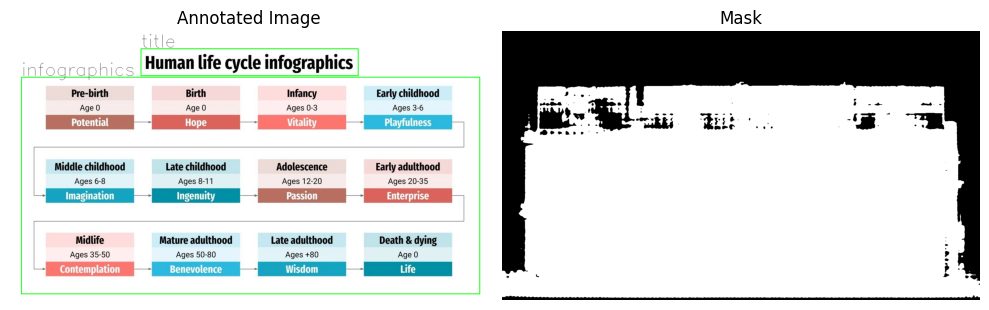

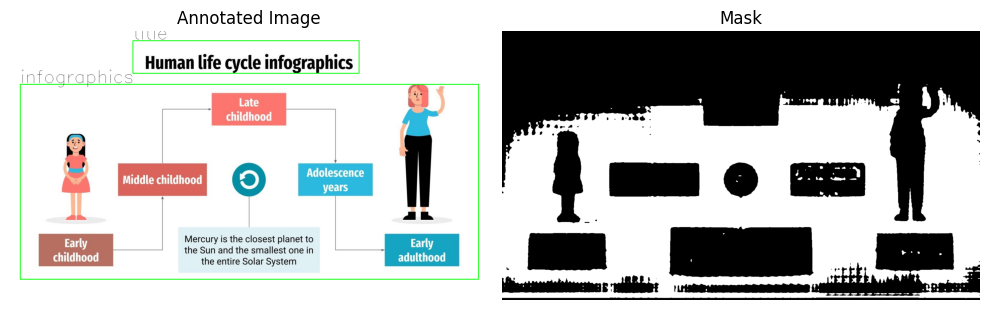

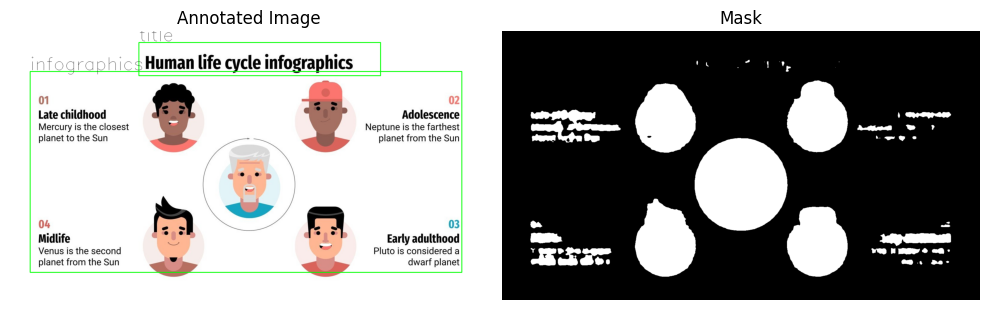

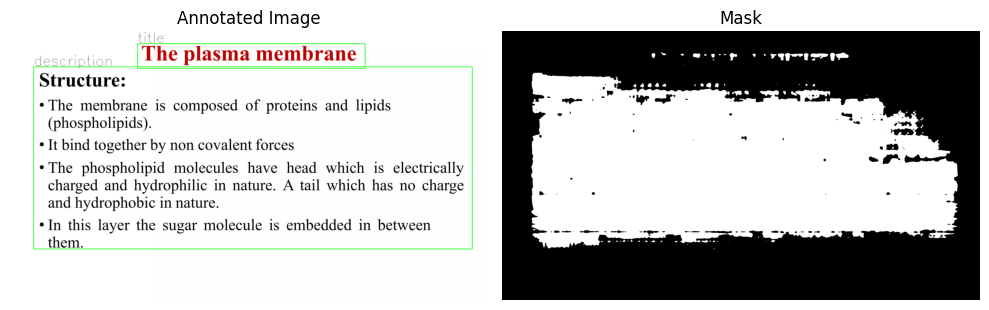

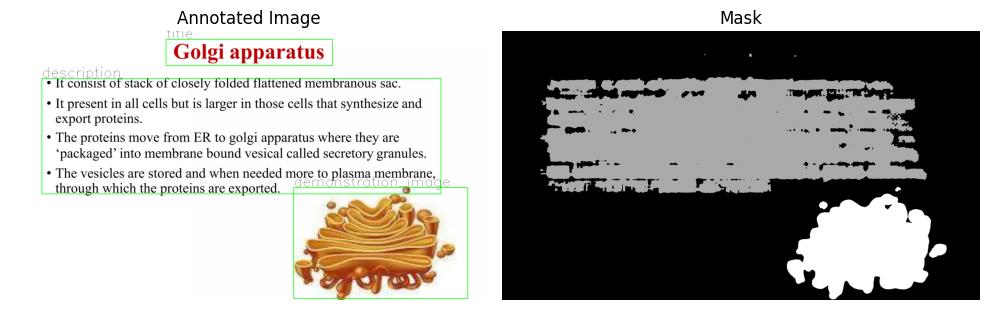

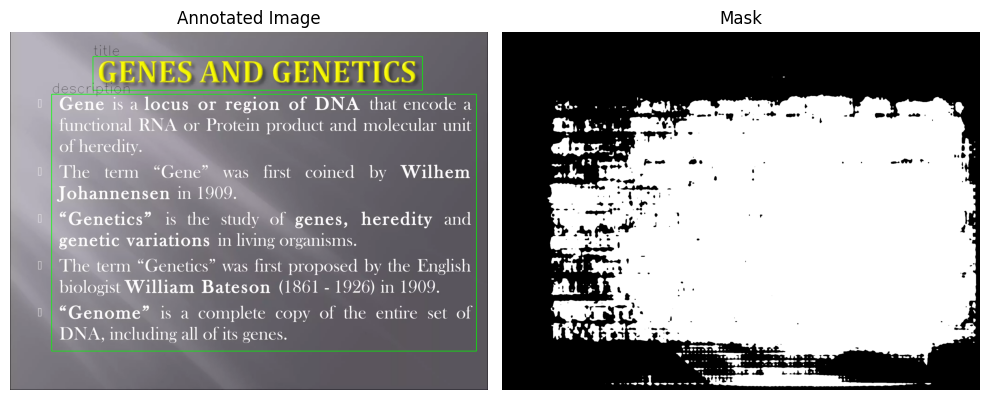

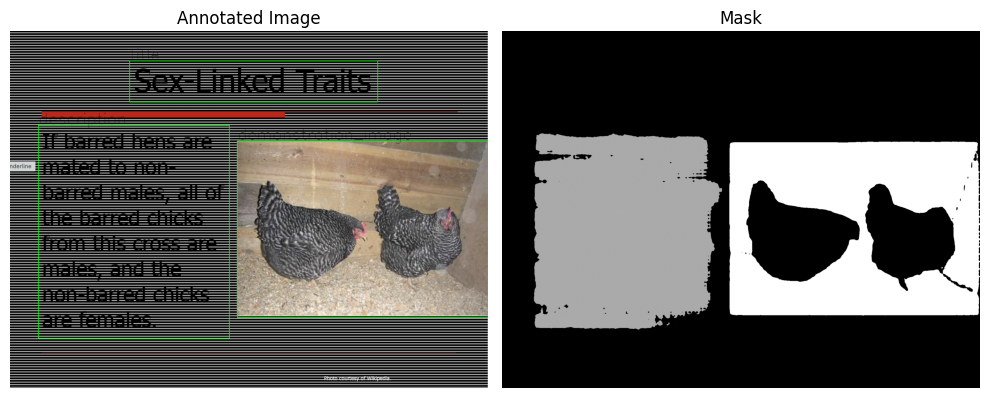

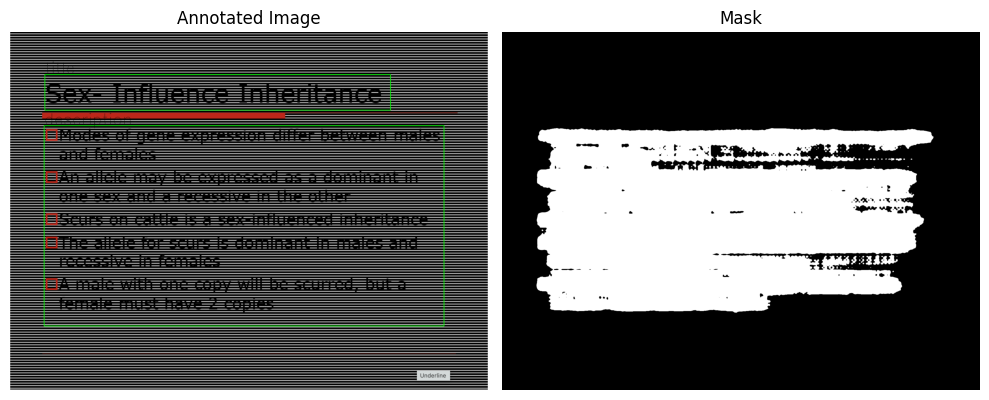

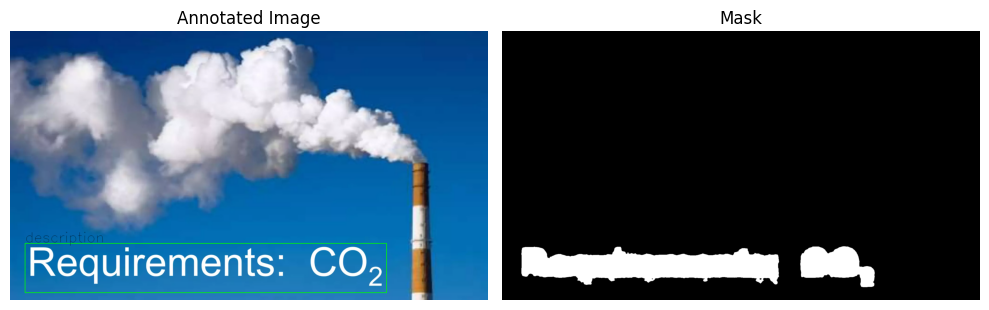

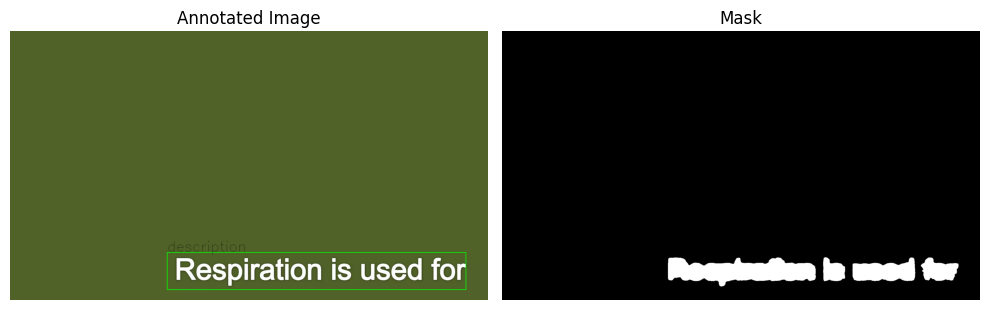

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def show_annotated_images_with_masks(eval_path, num_images):
    class_names = ['title', 'infographics', 'description', 'demonstration_image',
                   'equations', 'graph', 'recording_screen', 'board_data',
                   'board_controls', 'android']

    image_dir = os.path.join(eval_path, "images")
    label_dir = os.path.join(eval_path, "labels")
    mask_dir = os.path.join(eval_path, "masks3-multiclass-updated-eval")

    valid_exts = (".jpg", ".jpeg", ".png")
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)])[:num_images]
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(valid_exts)])[:num_images]

    for img_file, mask_file in zip(image_files, mask_files):
        base_name = os.path.splitext(img_file)[0]
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, base_name + ".txt")

        mask_path = os.path.join(mask_dir, mask_file)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if mask_path and os.path.exists(mask_path) else None

        if image is None:
            print(f"Skipping: {img_file} (Image not found or unreadable)")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Draw bounding boxes
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls, x, y, bw, bh = map(float, parts[:5])
                        x1 = int((x - bw / 2) * w)
                        y1 = int((y - bh / 2) * h)
                        x2 = int((x + bw / 2) * w)
                        y2 = int((y + bh / 2) * h)
                        label = class_names[int(cls)] if 0 <= int(cls) < len(class_names) else str(int(cls))
                        cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
                        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 1)

        # Display image and mask
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title("Annotated Image")
        axs[0].axis("off")

        if mask is not None:
            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title("Mask")
        else:
            axs[1].text(0.5, 0.5, "Mask not found", ha='center', va='center')
            axs[1].set_title("Mask")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()

# Call the function
show_annotated_images_with_masks("/content/dataset/complete_dataset_edited/eval", 10)


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to your masks3 folder
mask_dir = "/content/dataset/complete_dataset_edited/eval/masks3-multiclass-updated-eval"

# Get list of mask files
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))])[:20]

# Loop through and display
for mask_file in mask_files:
    mask_path = os.path.join(mask_dir, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    unique_values = np.unique(mask)
    print(f"{mask_file} - Unique values in mask:", unique_values)

    # plt.figure(figsize=(6, 6))
    # plt.imshow(mask, cmap='tab10')
    # plt.title(f"Visualized Mask: {mask_file}")
    # plt.axis("off")
    # plt.colorbar()
    # plt.show()


bio_presentation01_slide09_mask.png - Unique values in mask: [0 1]
bio_presentation01_slide17_mask.png - Unique values in mask: [0 1]
bio_presentation01_slide22_mask.png - Unique values in mask: [0 1]
bio_presentation02_slide05_mask.png - Unique values in mask: [0 2]
bio_presentation02_slide10_mask.png - Unique values in mask: [0 2 3]
bio_presentation03_slide02_mask.png - Unique values in mask: [0 2]
bio_presentation04_slide14_mask.png - Unique values in mask: [0 2 3]
bio_presentation04_slide17_mask.png - Unique values in mask: [0 2]
bio_presentation05_slide04_mask.png - Unique values in mask: [0 2]
bio_presentation05_slide12_mask.png - Unique values in mask: [0 2]
bio_presentation06_slide08_mask.png - Unique values in mask: [0 2]
bio_presentation06_slide09_mask.png - Unique values in mask: [0 2]
bio_presentation08_slide07_mask.png - Unique values in mask: [0 3]
bio_presentation08_slide08_mask.png - Unique values in mask: [0 3]
bio_presentation08_slide15_mask.png - Unique values in mas

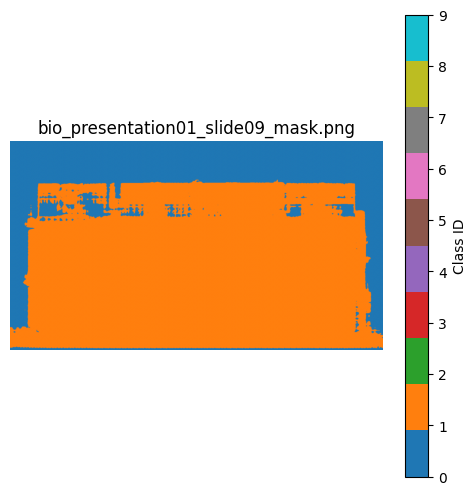

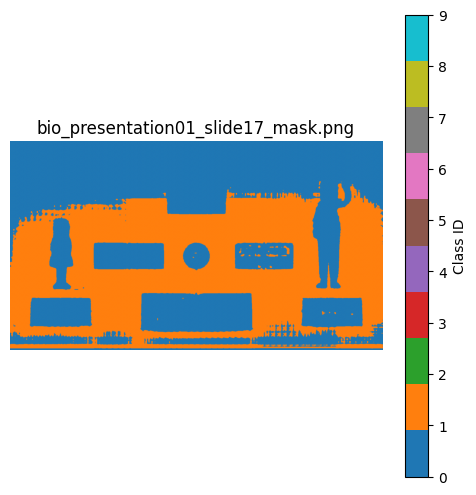

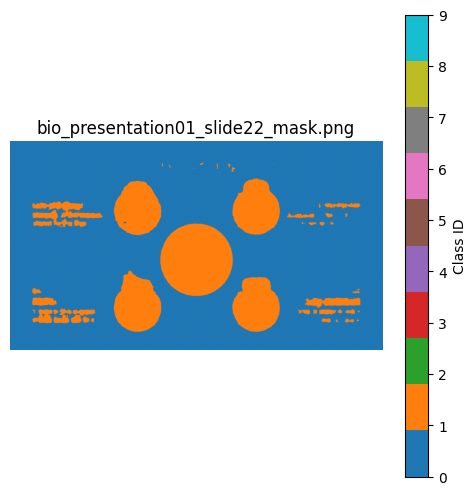

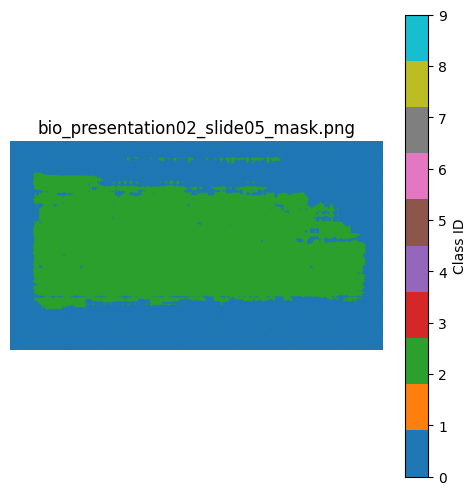

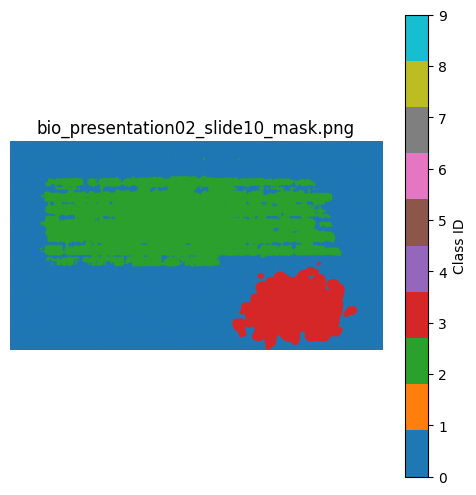

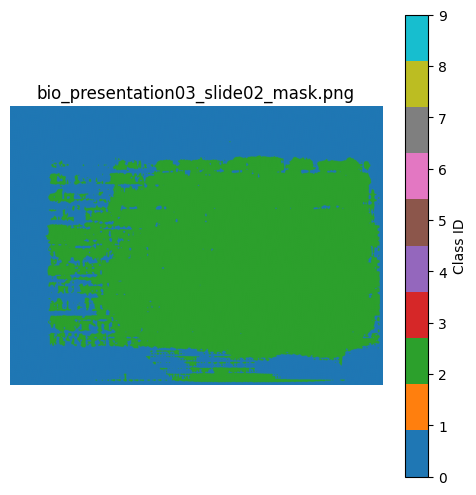

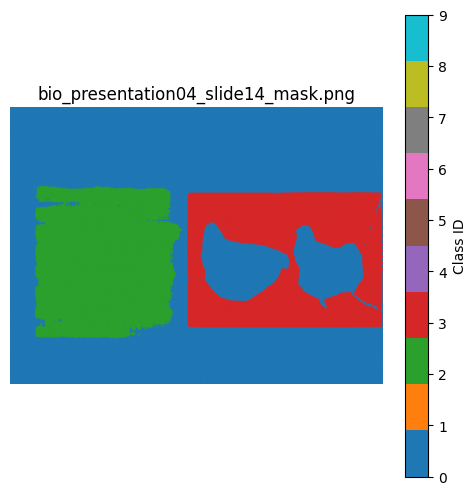

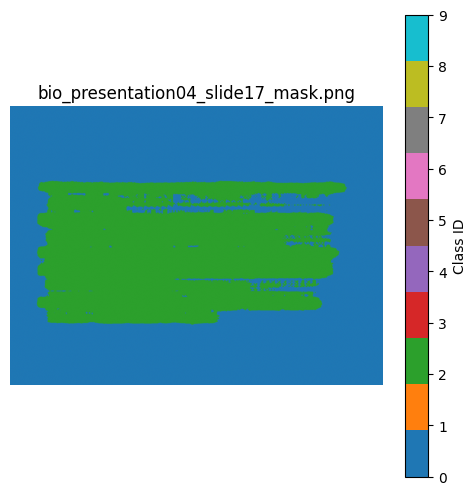

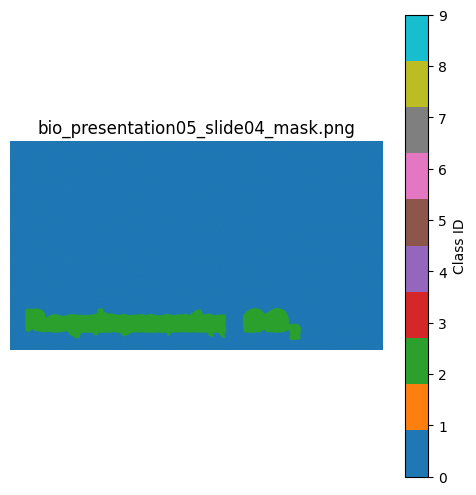

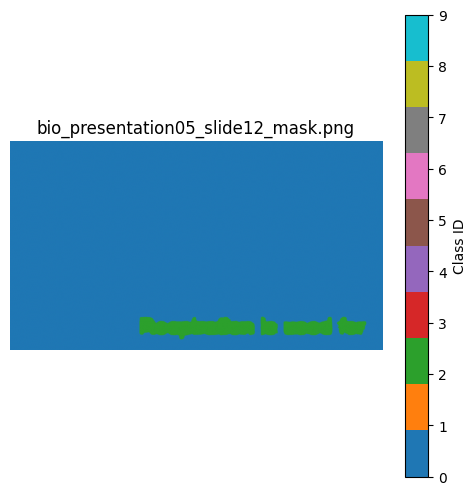

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directory and file setup
mask_dir = "/content/dataset/complete_dataset_edited/eval/masks3-multiclass-updated"
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])[:10]

# Visualization loop
for fname in mask_files:
    mask_path = os.path.join(mask_dir, fname)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    plt.figure(figsize=(6, 6))
    im = plt.imshow(mask, cmap='tab10', vmin=0, vmax=9)
    plt.title(fname)
    plt.axis("off")
    cbar = plt.colorbar(im, ticks=np.arange(0, 10))
    cbar.set_label("Class ID")
    plt.show()


## new labels

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_tight_box_from_mask(mask, class_id, original_box):
    x0, y0, x1, y1 = original_box
    region = mask[y0:y1, x0:x1]
    ys, xs = np.where(region == class_id)

    if len(xs) == 0 or len(ys) == 0:
        return None  # No tighter box found

    x_min = x0 + xs.min()
    x_max = x0 + xs.max()
    y_min = y0 + ys.min()
    y_max = y0 + ys.max()

    return x_min, y_min, x_max, y_max

def convert_to_yolo(x_min, y_min, x_max, y_max, width, height):
    cx = ((x_min + x_max) / 2) / width
    cy = ((y_min + y_max) / 2) / height
    bw = (x_max - x_min) / width
    bh = (y_max - y_min) / height
    return cx, cy, bw, bh

def process_labels_and_masks(label_dir, mask_dir, output_dir, img_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through the image files (assuming the images are in the img_dir)
    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)

        # Adjust mask file naming convention
        mask_path = os.path.join(mask_dir, img_file.rsplit('.', 1)[0] + '_mask.png')

        # Read the image mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load image {img_file}")
            continue

        height, width, _ = img.shape

        # Show the image using matplotlib (for debugging purposes)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"Displaying {img_file}")
        plt.axis('off')  # Hide axes for cleaner visualization
        plt.show()

        # Handle labels with the same base name as the image, but with the appropriate extension
        label_path = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + '.txt')  # Adjust label file extension
        output_label_path = os.path.join(output_dir, img_file.rsplit('.', 1)[0] + '.txt')

        with open(label_path, 'r') as label_file:
            lines = label_file.readlines()

        new_labels = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, box_width, box_height = map(float, parts[1:])

            # Convert the box from YOLO format to pixel coordinates
            x_min = int((x_center - box_width / 2) * width)
            y_min = int((y_center - box_height / 2) * height)
            x_max = int((x_center + box_width / 2) * width)
            y_max = int((y_center + box_height / 2) * height)

            # Check if the class_id is in the unique classes present in the mask
            if class_id in np.unique(mask):
                # Get the tight bounding box for each class in the mask
                tight_box = get_tight_box_from_mask(mask, class_id, (x_min, y_min, x_max, y_max))
                if tight_box:
                    x_min, y_min, x_max, y_max = tight_box
                    # Convert the tighter box back to YOLO format
                    new_box = convert_to_yolo(x_min, y_min, x_max, y_max, width, height)
                    new_labels.append(f"{class_id} " + " ".join(map(str, new_box)) + '\n')
                else:
                    # If no tight box is found, retain the original box
                    new_box = convert_to_yolo(x_min, y_min, x_max, y_max, width, height)
                    new_labels.append(f"{class_id} " + " ".join(map(str, new_box)) + '\n')
            else:
                # If class_id is not found in mask, keep the original bounding box
                new_box = convert_to_yolo(x_min, y_min, x_max, y_max, width, height)
                new_labels.append(f"{class_id} " + " ".join(map(str, new_box)) + '\n')

        # Save the updated labels
        with open(output_label_path, 'w') as output_label_file:
            output_label_file.writelines(new_labels)


# Set directories
label_dir = '/content/dataset/complete_dataset_edited/eval/labels'
mask_dir = '/content/dataset/complete_dataset_edited/eval/masks3-multiclass-updated-eval'
output_dir = '/content/dataset/complete_dataset_edited/eval/labels-updated'
img_dir = '/content/dataset/complete_dataset_edited/eval/images'

process_labels_and_masks(label_dir, mask_dir, output_dir, img_dir)


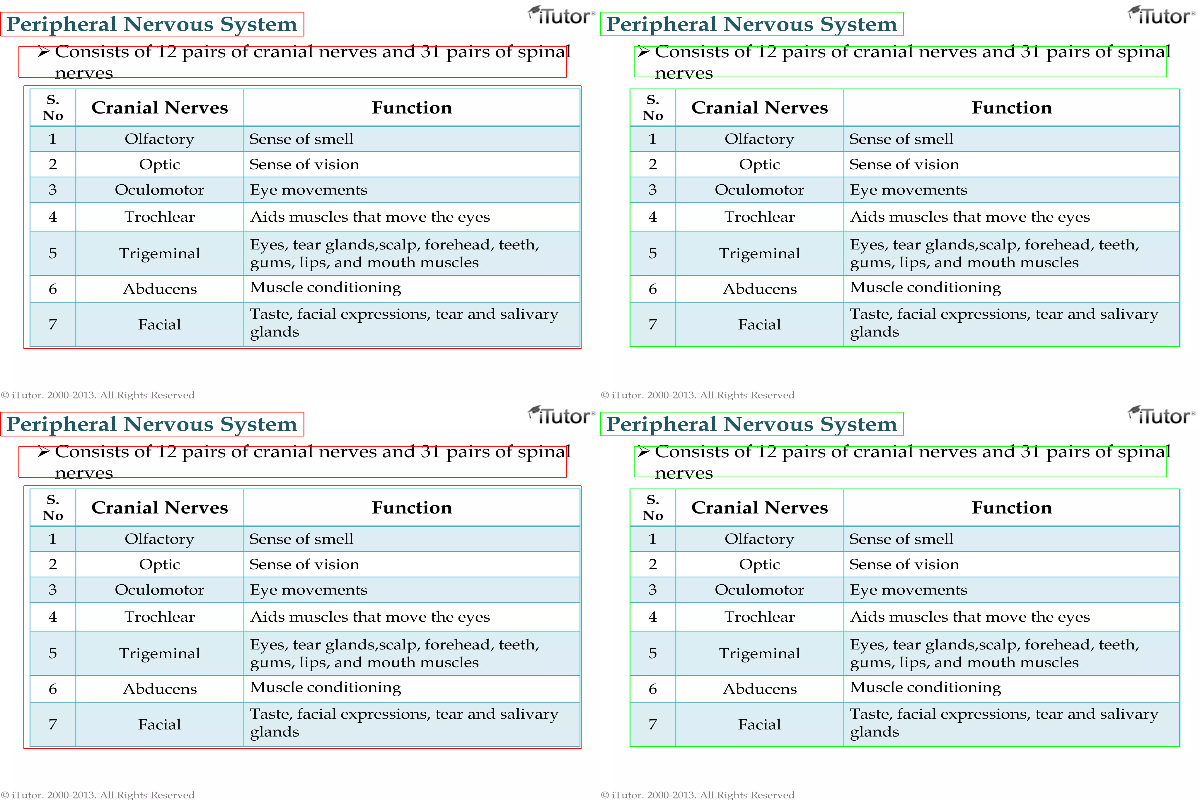

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def draw_bounding_boxes(image, labels, color=(0, 255, 0)):
    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center, y_center, box_width, box_height = map(float, parts[1:])

        # Convert YOLO box to pixel coordinates
        x_min = int((x_center - box_width / 2) * image.shape[1])
        y_min = int((y_center - box_height / 2) * image.shape[0])
        x_max = int((x_center + box_width / 2) * image.shape[1])
        y_max = int((y_center + box_height / 2) * image.shape[0])

        # Draw the bounding box on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

    return image

def load_labels(label_path):
    with open(label_path, 'r') as label_file:
        return label_file.readlines()

def visualize_bboxes(img_file1, img_file2, label_file1, label_file2, img_dir):
    img_path1 = os.path.join(img_dir, img_file1)
    img_path2 = os.path.join(img_dir, img_file2)

    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)

    # Load the labels
    old_labels = load_labels(label_file1)
    new_labels = load_labels(label_file2)

    # Make copies of the images to display old and new bounding boxes
    img_with_old_bboxes1 = img1.copy()
    img_with_new_bboxes1 = img1.copy()

    img_with_old_bboxes2 = img2.copy()
    img_with_new_bboxes2 = img2.copy()

    # Draw bounding boxes on the images
    img_with_old_bboxes1 = draw_bounding_boxes(img_with_old_bboxes1, old_labels, color=(0, 0, 255))  # Red for old
    img_with_new_bboxes1 = draw_bounding_boxes(img_with_new_bboxes1, new_labels, color=(0, 255, 0))  # Green for new

    img_with_old_bboxes2 = draw_bounding_boxes(img_with_old_bboxes2, old_labels, color=(0, 0, 255))  # Red for old
    img_with_new_bboxes2 = draw_bounding_boxes(img_with_new_bboxes2, new_labels, color=(0, 255, 0))  # Green for new

    # Stack images side by side
    combined_image1 = np.hstack((img_with_old_bboxes1, img_with_new_bboxes1))
    combined_image2 = np.hstack((img_with_old_bboxes2, img_with_new_bboxes2))

    # Stack two combined images vertically
    final_combined_image = np.vstack((combined_image1, combined_image2))

    # Resize for better display
    final_combined_image_resized = cv2.resize(final_combined_image, (1200, 800))

    # Display the combined image
    cv2_imshow(final_combined_image_resized)

# Example usage
img_file1 = '/content/dataset/complete_dataset_edited/eval/images/bio_presentation13_slide17.png'  # Replace with the actual image filenames
img_file2 = '/content/dataset/complete_dataset_edited/eval/images/bio_presentation13_slide17.png'
label_file1 = '/content/dataset/complete_dataset_edited/eval/labels/bio_presentation13_slide17.txt'  # Replace with the path to the old label file
label_file2 = '/content/dataset/complete_dataset_edited/eval/labels-updated/bio_presentation13_slide17.txt'  # Replace with the path to the new label file
# Example usage
# img_file1 = '/content/dataset/complete_dataset_edited/eval/images/bio_presentation01_slide09.png'  # Replace with the actual image filenames
# img_file2 = '/content/dataset/complete_dataset_edited/eval/images/bio_presentation01_slide09.png'
# label_file1 = '/content/dataset/complete_dataset_edited/eval/labels/bio_presentation01_slide09.txt'  # Replace with the path to the old label file
# label_file2 = '/content/dataset/complete_dataset_edited/eval/labels-updated/bio_presentation01_slide09.txt'  # Replace with the path to the new label file
img_dir = '/content/dataset/complete_dataset_edited/eval/images'  # Path to the image directory

visualize_bboxes(img_file1, img_file2, label_file1, label_file2, img_dir)


In [ ]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def draw_bounding_boxes(image, labels, color=(0, 255, 0)):
    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center, y_center, box_width, box_height = map(float, parts[1:])

        # Convert YOLO box to pixel coordinates
        x_min = int((x_center - box_width / 2) * image.shape[1])
        y_min = int((y_center - box_height / 2) * image.shape[0])
        x_max = int((x_center + box_width / 2) * image.shape[1])
        y_max = int((y_center + box_height / 2) * image.shape[0])

        # Draw the bounding box on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

    return image

def load_labels(label_path):
    with open(label_path, 'r') as label_file:
        return label_file.readlines()

def visualize_bboxes_side_by_side(img_dir, label_dir, updated_label_dir):
    # Loop through the image files in the image directory
    for img_file in os.listdir(img_dir):
        if img_file.endswith(".png"):  # You can change this to match your image format
            img_path = os.path.join(img_dir, img_file)

            # Generate paths for old and updated labels
            old_label_path = os.path.join(label_dir, img_file.replace(".png", ".txt"))  # Assuming labels are text files
            new_label_path = os.path.join(updated_label_dir, img_file.replace(".png", ".txt"))

            if os.path.exists(old_label_path) and os.path.exists(new_label_path):
                # Read the image
                img = cv2.imread(img_path)

                # Load the labels
                old_labels = load_labels(old_label_path)
                new_labels = load_labels(new_label_path)

                # Make copies of the images to draw the old and new bounding boxes
                img_with_old_bboxes = img.copy()
                img_with_new_bboxes = img.copy()

                # Draw bounding boxes on the images
                img_with_old_bboxes = draw_bounding_boxes(img_with_old_bboxes, old_labels, color=(0, 0, 255))  # Red for old
                img_with_new_bboxes = draw_bounding_boxes(img_with_new_bboxes, new_labels, color=(0, 255, 0))  # Green for new

                # Stack images side by side
                combined_image = np.hstack((img_with_old_bboxes, img_with_new_bboxes))

                # Resize for better display
                combined_image_resized = cv2.resize(combined_image, (1200, 800))

                # Display the combined image
                cv2_imshow(combined_image_resized)

# Example usage
img_dir = '/content/dataset/complete_dataset_edited/eval/images'  # Path to the image directory
label_dir = '/content/dataset/complete_dataset_edited/eval/labels'  # Path to the old labels
updated_label_dir = '/content/dataset/complete_dataset_edited/eval/labels-updated'  # Path to the updated labels

visualize_bboxes_side_by_side(img_dir, label_dir, updated_label_dir)



In [ ]:
!cp -r /content/runs /content/drive/MyDrive/